In [28]:
from envs import ES, Reinforce, MLPPolicy
from util import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gym
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")

## Cart Pole comparison.

In [2]:
#define different seeds
seeds = np.arange(1, 20)


def get_env_function():
    """
    Generates an instance of environment and returns it.
    """
    env = gym.make("CartPole-v0")

    if hasattr(env, '_max_episode_steps'):
        env = env.env
        
    return env

env = get_env_function()

n_actions = env.action_space.n
state_dim = env.observation_space.shape

print("Total actions and dim: {} act. , {} dim.".format(n_actions, state_dim))

Total actions and dim: 2 act. , (4,) dim.


In [3]:
methods = [ES, Reinforce]
names = ["Evolution", "Reinforce"]

def get_comparison(methods, names, seeds, bound):
    results = []
    
    for seed in tqdm(seeds):
        np.random.seed(seed)
        torch.manual_seed(seed)
        for i, method in enumerate(methods):
            if i == 0:
                model = MLPPolicy(state_dim[0], n_actions, 100, discrete=True)
                alg = ES(get_env_function, model, std=0.01, lr=0.001, n_threads = 1, n_samples=128)
            else:
                agent = nn.Sequential(
                    nn.Linear(state_dim[0], 100, bias=False),
                    nn.ReLU(),
                    nn.Linear(100, 100, bias=False),
                    nn.ReLU(),
                    nn.Linear(100, n_actions, bias=False)
                )
                alg = Reinforce(agent, get_env_function(), seed)
            
            alg.train(bound)
            results.append(alg.log)
    return results
res_cartpole = get_comparison(methods, names, seeds, 400)

  0%|                                                    | 0/19 [00:00<?, ?it/s]/Users/timurmudarisov/Downloads/util.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(model(tens)).cpu().numpy()
/Users/timurmudarisov/Downloads/util.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  states = torch.tensor(states, dtype=torch.float32)
100%|███████████████████████████████████████████| 19/19 [28:56<00:00, 91.41s/it]


In [29]:
for i in range(len(res_cartpole)):
    for j in range(len(res_cartpole[i])):
        res_cartpole[i][j] = (res_cartpole[i][j][0], j)

res_cartpole_es = np.array(res_cartpole)[np.arange(0, 38, 2).astype(int)]
res_cartpole_reinforce = np.array(res_cartpole)[np.arange(1, 38, 2).astype(int)]

In [49]:
def get_index(results, values):
    dct = {}
    for value in values:
        dct[value] = []
        for res in results:
            for i in range(len(res)):
                if res[i][0] > value:
                    dct[value].append(i)
                    break
    return dct

values_net = np.arange(50, 450, 50)

dct_es_cart = get_index(res_cartpole_es, values_net)
dct_reinforce_cart = get_index(res_cartpole_reinforce, values_net)

mean_es, mean_reinforce = [], []
std_es, std_reinforce = [], []

for val in values_net:
    mean_es.append(np.array(dct_es_cart[val]).mean())
    std_es.append(np.array(dct_es_cart[val]).std())
    mean_reinforce.append(np.array(dct_reinforce_cart[val]).mean())
    std_reinforce.append(np.array(dct_reinforce_cart[val]).std())

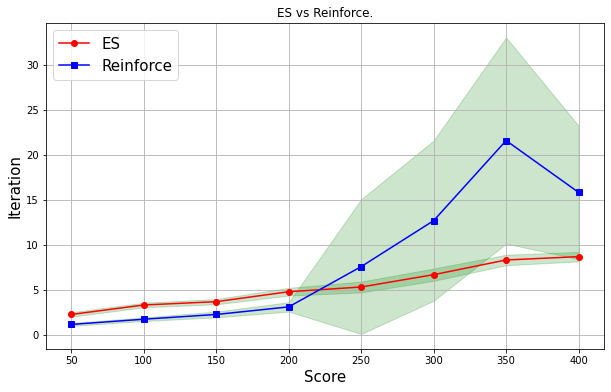

In [84]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_title("ES vs Reinforce.")
ax.plot(mean_es, marker='o', color='red', label='ES')
ax.fill_between(np.arange(0, 8),
                mean_es - 1.96 / np.sqrt(len(seeds)) * np.array(std_es),
                mean_es + 1.96 / np.sqrt(len(seeds)) * np.array(std_es),
               color='green', alpha=0.2)
ax.fill_between(np.arange(0, 8),
                mean_reinforce - 1.96 / np.sqrt(len(seeds)) * np.array(std_reinforce),
                mean_reinforce + 1.96 / np.sqrt(len(seeds)) * np.array(std_reinforce),
               color='green', alpha=0.2)
ax.plot(mean_reinforce, marker='s', color='blue', label='Reinforce')
ax.grid()
ax.set_xticklabels(np.arange(0, 450, 50))
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel("Score", fontsize=15)
ax.set_ylabel("Iteration", fontsize=15)

plt.show()